# Supervised Machine Learning (SML)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from joblib import dump, load
from IPython.display import display, Markdown
from sklearn.metrics import auc, precision_recall_curve

## Loading the data

In [2]:
# Load the data
file_path = 'prelabel_env_rc.xlsx'
df = pd.read_excel(file_path)

# Separate the labeled and unlabeled data
labeled_data = df[df['EoL_Recycling'] != -1].copy()
unlabeled_data = df[df['EoL_Recycling'] == -1].copy()

## Preprocessing

In [3]:
# Define necessary NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text data
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'%', ' percent ', text)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = text.lower()
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    stopwords_set = set(stopwords.words('english')) | {'study', 'results', 'conclusion', 'methods', 'data', 'analysis', 'background', 'elsevier', 'ASCE', '@', 'copyright', '(C)', 'Ltd.', 'authors', 'institute', 'IEEE'}
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(['number' if word.isdigit() else word for word in words])

# Apply preprocessing
labeled_data['Abstract_preprocessed'] = labeled_data['Abstract'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.85, strip_accents='unicode', max_features=None, use_idf=True, smooth_idf=True, sublinear_tf=True)
X = vectorizer.fit_transform(labeled_data['Abstract_preprocessed'])
y = labeled_data['EoL_Recycling']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deassunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deassunc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Train-Test split

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model hyperparameters

In [5]:
models_params = {
    "RandomForest": (RandomForestClassifier(random_state=42, class_weight='balanced'), {
        'model__n_estimators': [5, 10, 100, 200],
        'model__max_depth': [None],
        'model__min_samples_leaf': [1, 2],
        'model__min_samples_split': [2, 5],
        'model__max_features': ['sqrt'],      
    }),
    "SVC": (SVC(probability=True, random_state=42, class_weight='balanced'), {
        'model__C': [0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__probability': [True],
    }),
    "MultinomialNB": (MultinomialNB(), {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__fit_prior': [True],
    }),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.05, 0.1, 1.0],
        'model__max_depth': [3, 4, 7],
        'model__subsample': [1.0],
    }),
    "LogisticRegression": (LogisticRegression(random_state=42, class_weight='balanced'), {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'model__max_iter': [100, 200, 300],
    }),
    "DecisionTree": (DecisionTreeClassifier(random_state=42, class_weight='balanced'), {
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    }),
    "MLPClassifier": (MLPClassifier(random_state=42), {
        'model__hidden_layer_sizes': [(50, 50, 50)],
        'model__activation': ['tanh', 'relu'],
        'model__solver': ['lbfgs', 'adam'],
        'model__alpha': [0.001, 0.01],
        'model__learning_rate': ['constant', 'adaptive'],
        'model__max_iter': [200],
    })
}

## Evaluating function

Processing RandomForest...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Best hyperparameters for RandomForestClassifier: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        33
           1       0.81      0.74      0.77        23

    accuracy                           0.82        56
   macro avg       0.82      0.81      0.81        56
weighted avg       0.82      0.82      0.82        56

Model Accuracy: 0.8214285714285714


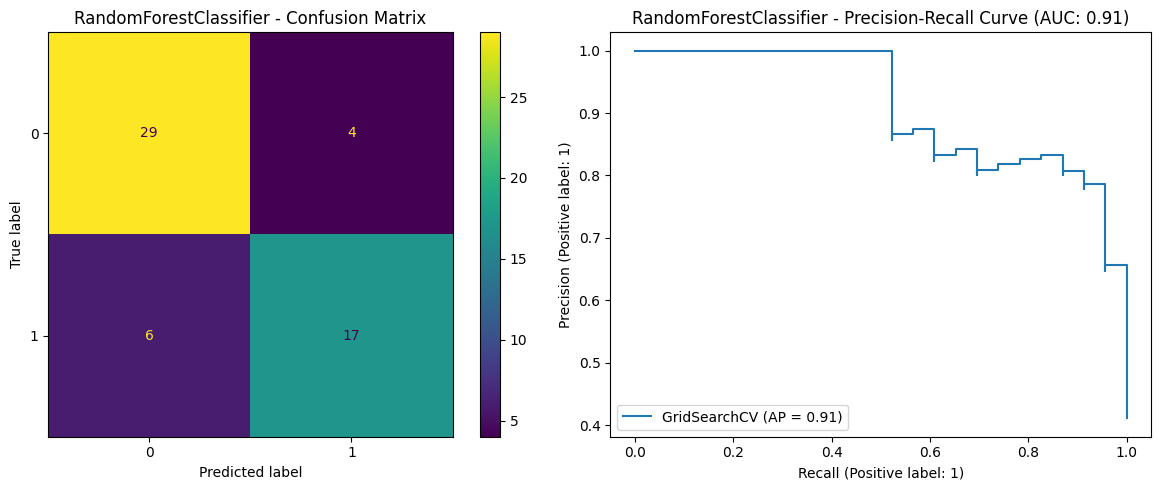

Processing SVC...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Best hyperparameters for SVC: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear', 'model__probability': True}

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        33
           1       0.94      0.74      0.83        23

    accuracy                           0.88        56
   macro avg       0.89      0.85      0.87        56
weighted avg       0.88      0.88      0.87        56

Model Accuracy: 0.875


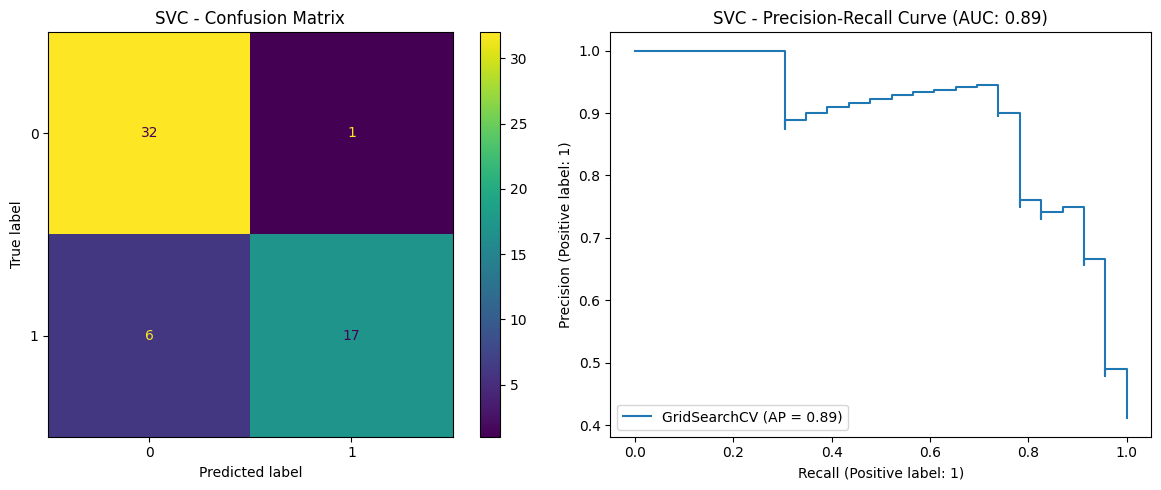

Processing MultinomialNB...
Fitting 10 folds for each of 5 candidates, totalling 50 fits

Best hyperparameters for MultinomialNB: {'model__alpha': 0.1, 'model__fit_prior': True}

MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        33
           1       0.74      0.74      0.74        23

    accuracy                           0.79        56
   macro avg       0.78      0.78      0.78        56
weighted avg       0.79      0.79      0.79        56

Model Accuracy: 0.7857142857142857


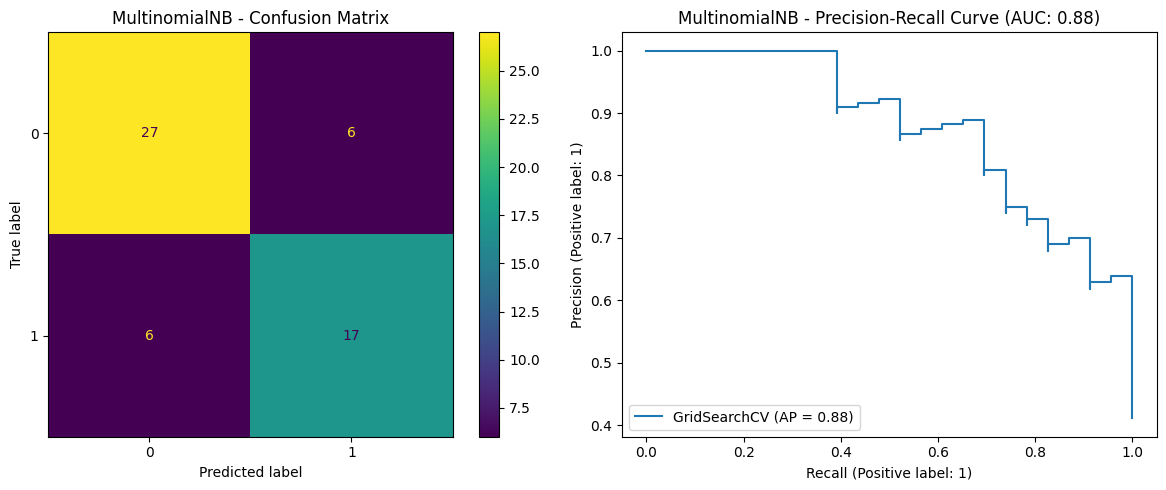

Processing GradientBoosting...
Fitting 10 folds for each of 27 candidates, totalling 270 fits

Best hyperparameters for GradientBoostingClassifier: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}

GradientBoostingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        33
           1       0.86      0.78      0.82        23

    accuracy                           0.86        56
   macro avg       0.86      0.85      0.85        56
weighted avg       0.86      0.86      0.86        56

Model Accuracy: 0.8571428571428571


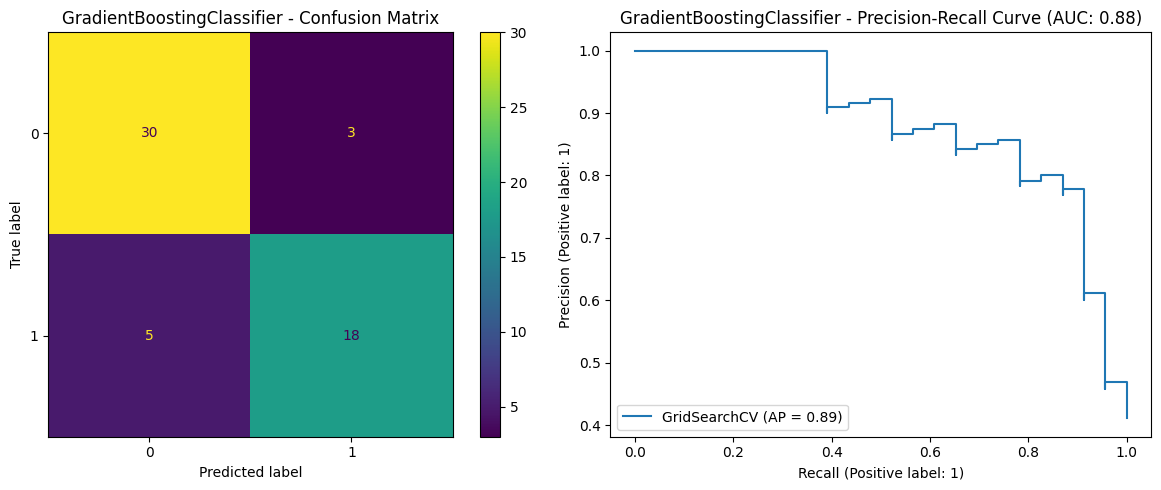

Processing LogisticRegression...
Fitting 10 folds for each of 90 candidates, totalling 900 fits

Best hyperparameters for LogisticRegression: {'model__C': 0.1, 'model__max_iter': 100, 'model__solver': 'saga'}

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        33
           1       0.75      0.65      0.70        23

    accuracy                           0.77        56
   macro avg       0.76      0.75      0.75        56
weighted avg       0.77      0.77      0.76        56

Model Accuracy: 0.7678571428571429


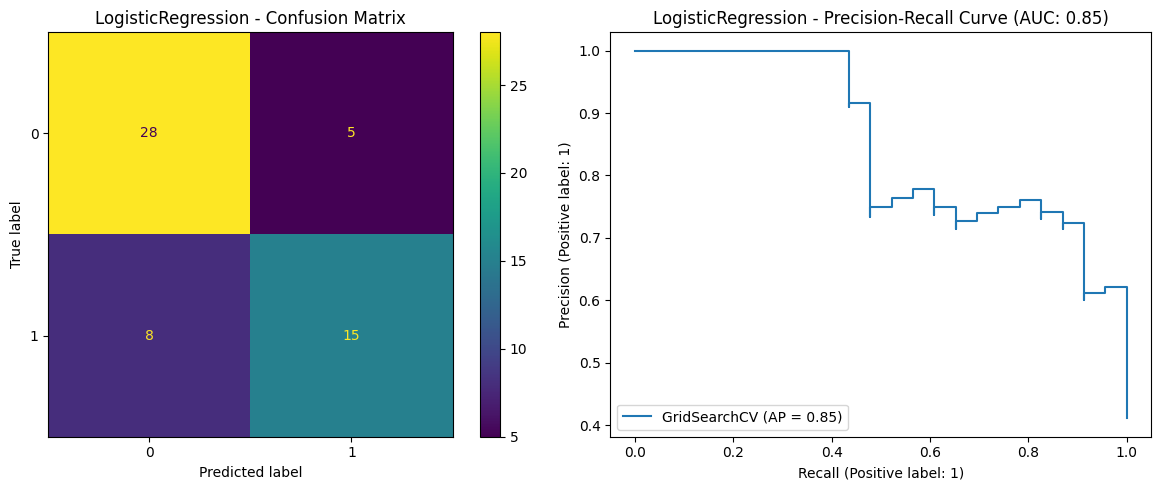

Processing DecisionTree...
Fitting 10 folds for each of 36 candidates, totalling 360 fits

Best hyperparameters for DecisionTreeClassifier: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        33
           1       0.82      0.78      0.80        23

    accuracy                           0.84        56
   macro avg       0.84      0.83      0.83        56
weighted avg       0.84      0.84      0.84        56

Model Accuracy: 0.8392857142857143


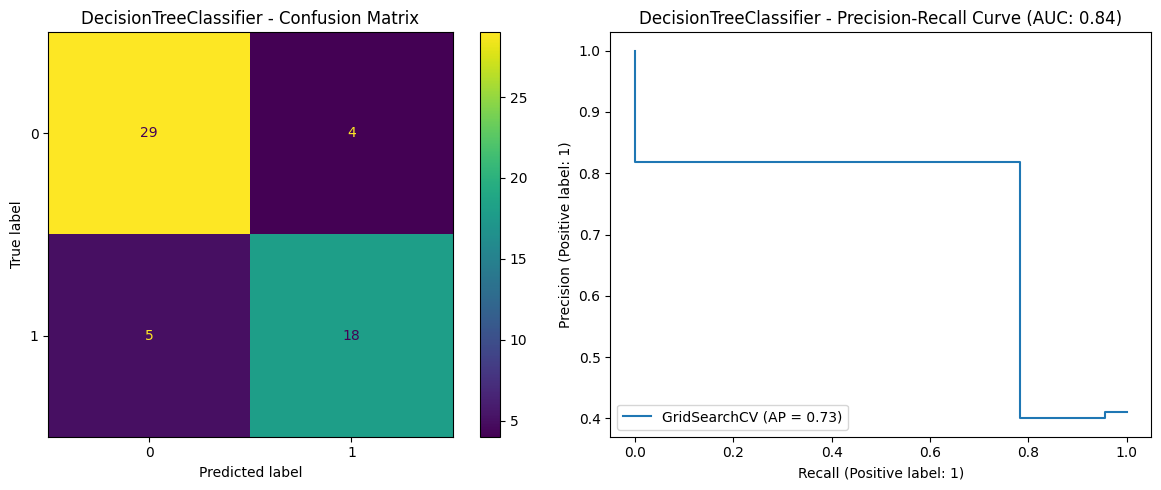

Processing MLPClassifier...
Fitting 10 folds for each of 16 candidates, totalling 160 fits

Best hyperparameters for MLPClassifier: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50, 50), 'model__learning_rate': 'constant', 'model__max_iter': 200, 'model__solver': 'lbfgs'}

MLPClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        33
           1       0.76      0.83      0.79        23

    accuracy                           0.82        56
   macro avg       0.82      0.82      0.82        56
weighted avg       0.83      0.82      0.82        56

Model Accuracy: 0.8214285714285714


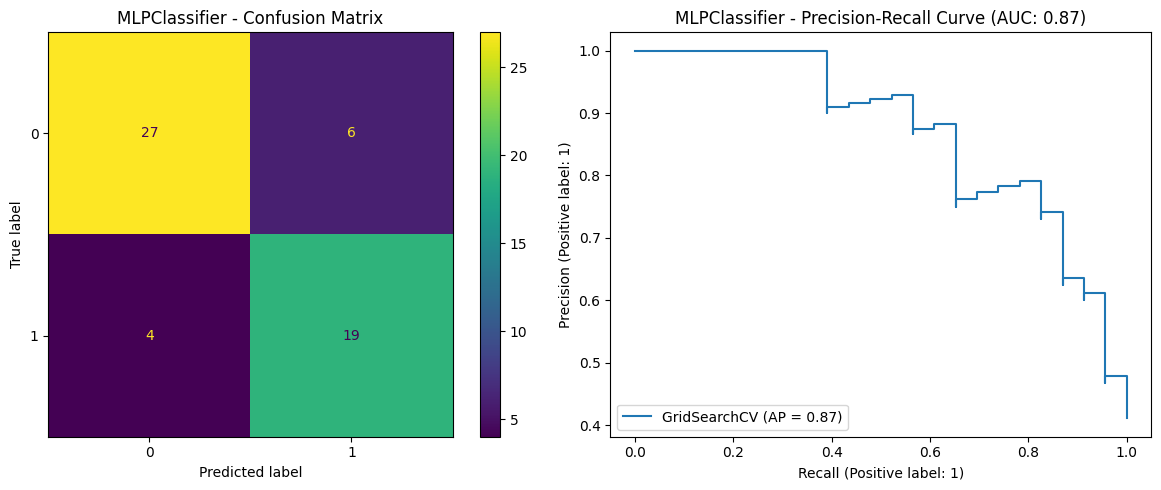

## Optimal model: **SVC** (F1-score = **0.83**)

In [6]:
def train_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=10)
    # Grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_macro', verbose=2, n_jobs=-1)
    # Fit model
    grid_search.fit(X_train, y_train)

    # Best hyperparameters
    print(f"\nBest hyperparameters for {type(model).__name__}: {grid_search.best_params_}")

    # Evaluate the model on the test set
    y_pred = grid_search.predict(X_test)
    # Classification report
    print(f"\n{type(model).__name__} Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    # Model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Model Accuracy:", accuracy)

    # Create the plots immediately after displaying the results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion matrix plot using updated function
    ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, ax=axs[0])
    axs[0].set_title(f"{type(model).__name__} - Confusion Matrix")

    # Precision-recall curve plot using updated function
    precision, recall, _ = precision_recall_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay.from_estimator(grid_search, X_test, y_test, ax=axs[1])
    axs[1].set_title(f"{type(model).__name__} - Precision-Recall Curve (AUC: {pr_auc:.2f})")

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Return the best estimator and its accuracy
    return grid_search.best_estimator_, report, accuracy

# Variables to track the best model
best_score = 0
best_model_name = ""
best_model = None

# Loop to train and evaluate each model
for model_name, (model, params) in models_params.items():
    print(f"Processing {model_name}...")
    # trained_model, accuracy = train_evaluate_model(model, params, X_train, y_train, X_test, y_test)
    trained_model, report, accuracy = train_evaluate_model(model, params, X_train, y_train, X_test, y_test)
    
    # Extract the F1 Score for the positive class
    f1 = report['1']['f1-score']

    # Check if the current model's F1 Score is the best so far
    if f1 > best_score:
        best_score = f1
        best_model = trained_model
        best_model_name = model_name
        
    # # Check if the current model is the best so far
    # if accuracy > best_score:
    #     best_score = accuracy
    #     best_model = trained_model
    #     best_model_name = model_name

# Identify the best model
# display(Markdown(f"## Optimal best: **{best_model_name}** (Accuracy of **{best_score:.2%}**)"))
display(Markdown(f"## Optimal model: **{best_model_name}** (F1-score = **{best_score:.2f}**)"))

## Saving

In [7]:
# Save the best model and vectorizer
dump(best_model, 'best_model_env_rc.joblib')
dump(vectorizer, 'tfidf_vectorizer_env_rc.joblib')

['tfidf_vectorizer_env_rc.joblib']

## Performing

In [8]:
# Load the saved best model and TF-IDF vectorizer
best_model = load('best_model_env_rc.joblib')
vectorizer = load('tfidf_vectorizer_env_rc.joblib')

# Prepare the unlabeled data
# Note: Assuming you've already applied any necessary preprocessing when loading the data
unlabeled_data['Abstract_preprocessed'] = unlabeled_data['Abstract'].apply(preprocess_text)
X_unlabeled = vectorizer.transform(unlabeled_data['Abstract_preprocessed'])

# Make predictions on the unlabeled data
predictions = best_model.predict(X_unlabeled)

# Add the predictions back into the DataFrame of unlabeled data
unlabeled_data['EoL_Recycling'] = predictions

# Combine the originally labeled data and the now labeled (previously unlabeled) data
combined_data = pd.concat([labeled_data, unlabeled_data])

# Save the combined DataFrame to a new Excel file
combined_data.to_excel('predic_env_rc.xlsx', index=False)